In [1]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Function to set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch (CPU)
    torch.cuda.manual_seed(seed)  # PyTorch (GPU)
    torch.cuda.manual_seed_all(seed)  # All GPU devices
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable automatic optimization for convolution algorithms

# Seed worker function for data loading
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % (2**32)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Set random seeds
set_seed(42)

# Load CSV data
data_path = 'F:/university/milan/third semester/audio pattern/final/datasets/Data/features_3_sec.csv'
df = pd.read_csv(data_path)

# Preprocess the features
X = np.array(df.drop(['filename', 'label'], axis=1))  # Drop non-feature columns
y = np.array(df['label'].values)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
#pca = PCA(n_components=39, random_state=42)
#X_pca = pca.fit_transform(X_scaled)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Stratified Shuffle Split for train, validation, and test
# Step 1: Stratified Shuffle Split for initial train and test split
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(ss_split.split(X_scaled, y_encoded))

# Step 2: Further split the train set into train and validation sets
# 80% training and 20% validation
train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=42)

# Extracting the data
X_train, X_test, y_train, y_test = X_scaled[train_indices], X_scaled[test_indices], y_encoded[train_indices], y_encoded[test_indices]
X_val, y_val = X_scaled[val_indices], y_encoded[val_indices]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataset class
class MusicGenreDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# DataLoader for batching
train_dataset = MusicGenreDataset(X_train_tensor, y_train_tensor)
val_dataset = MusicGenreDataset(X_val_tensor, y_val_tensor)
test_dataset = MusicGenreDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=seed_worker)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, worker_init_fn=seed_worker)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, worker_init_fn=seed_worker)

In [11]:
# Improved CNN Model with 1D Convolutions and Custom Fully Connected Layers
class ImprovedCNNWithBatchNorm(nn.Module):
    def __init__(self):
        super(ImprovedCNNWithBatchNorm, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)  # Batch norm for conv1
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)  # Batch norm for conv2
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduces sequence length by half
        
        # Fully connected layers with batch normalization
        # input size after pooling: 32 * (X_train_tensor.shape[1] // 2)
        self.fc1 = nn.Linear(32 * (X_train_tensor.shape[1] // 2), 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, 512)
        self.bn_fc3 = nn.BatchNorm1d(512)
        
        self.fc4 = nn.Linear(512, 1024)
        self.bn_fc4 = nn.BatchNorm1d(1024)
        
        self.fc5 = nn.Linear(1024, 512)
        self.bn_fc5 = nn.BatchNorm1d(512)
        
        self.fc6 = nn.Linear(512, 10)  # Output layer
        
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Reshape input for convolutional layers: (batch_size, channels, sequence_length)
        x = x.unsqueeze(1)  # Add channel dimension: (batch_size, 1, sequence_length)
        
        # Convolutional layers with batch normalization and ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Pooling reduces sequence length
        
        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with batch normalization, dropout, and ReLU
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_fc3(self.fc3(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_fc4(self.fc4(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_fc5(self.fc5(x)))
        x = self.dropout(x)
        
        x = self.fc6(x)  # Final output layer
        return x

Epoch 1/25, Train Loss: 1.7361, Val Loss: 1.2021
Epoch 2/25, Train Loss: 1.1966, Val Loss: 0.9182
Epoch 3/25, Train Loss: 1.0167, Val Loss: 0.7523
Epoch 4/25, Train Loss: 0.8621, Val Loss: 0.6808
Epoch 5/25, Train Loss: 0.7803, Val Loss: 0.6170
Epoch 6/25, Train Loss: 0.7175, Val Loss: 0.5799
Epoch 7/25, Train Loss: 0.6394, Val Loss: 0.5467
Epoch 8/25, Train Loss: 0.5873, Val Loss: 0.5116
Epoch 9/25, Train Loss: 0.5636, Val Loss: 0.5185
Epoch 10/25, Train Loss: 0.5105, Val Loss: 0.4897
Epoch 11/25, Train Loss: 0.4601, Val Loss: 0.4700
Epoch 12/25, Train Loss: 0.4454, Val Loss: 0.4472
Epoch 13/25, Train Loss: 0.4104, Val Loss: 0.4394
Epoch 14/25, Train Loss: 0.3899, Val Loss: 0.4485
Epoch 15/25, Train Loss: 0.3694, Val Loss: 0.4329
Epoch 16/25, Train Loss: 0.3568, Val Loss: 0.4211
Epoch 17/25, Train Loss: 0.3417, Val Loss: 0.3968
Epoch 18/25, Train Loss: 0.3160, Val Loss: 0.4050
Epoch 19/25, Train Loss: 0.3116, Val Loss: 0.4196
Epoch 20/25, Train Loss: 0.2926, Val Loss: 0.4066
Epoch 21/

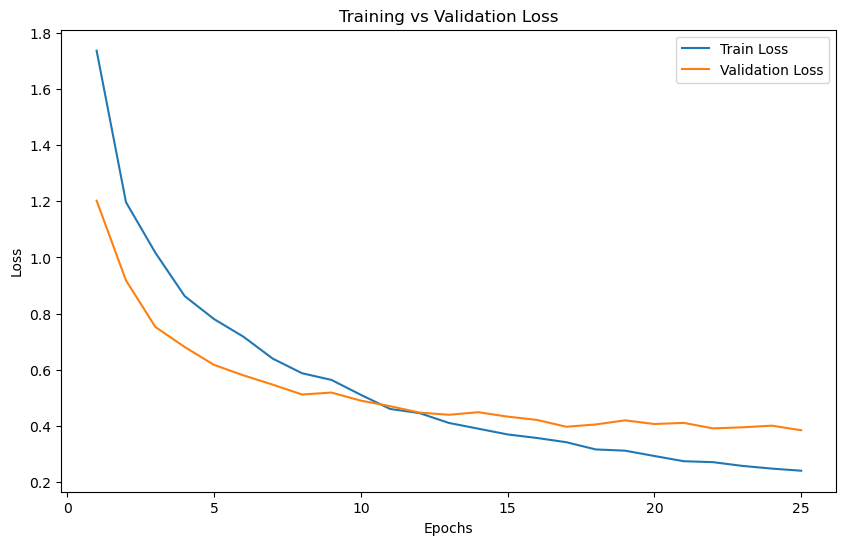

Tuned Classification Report:
              precision    recall  f1-score   support

       blues       0.86      0.89      0.87       200
   classical       0.94      0.94      0.94       199
     country       0.77      0.85      0.81       199
       disco       0.84      0.88      0.86       200
      hiphop       0.93      0.90      0.91       200
        jazz       0.88      0.86      0.87       200
       metal       0.94      0.92      0.93       200
         pop       0.91      0.86      0.89       200
      reggae       0.88      0.83      0.86       200
        rock       0.80      0.80      0.80       200

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      0.87      1998



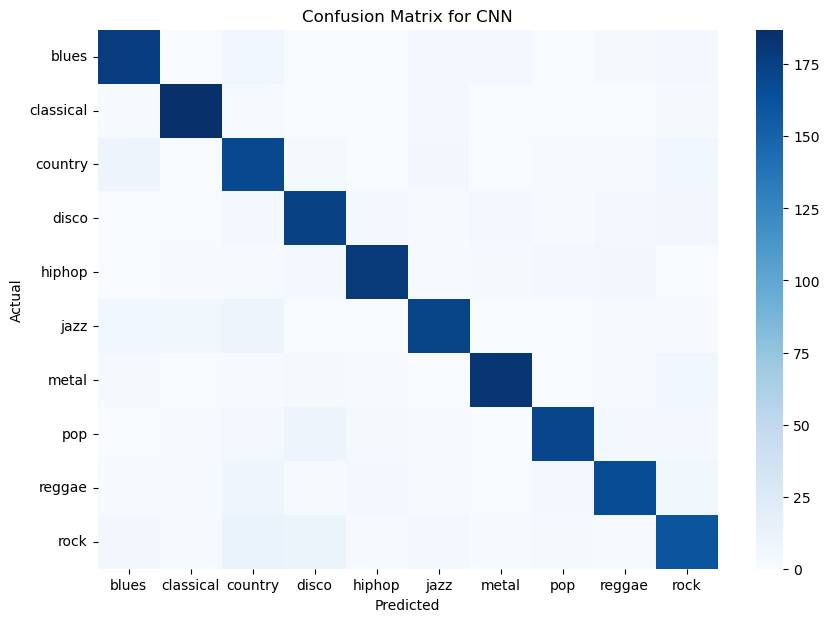

In [13]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Plotting losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()

    return model

# Evaluate Model
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
    
    # Classification Report for the tuned model
    class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
    print("Tuned Classification Report:")
    print(class_report)

    # Confusion Matrix heatmap
    plt.figure(figsize=(10, 7))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot= False, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix for CNN')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Initialize model, criterion, and optimizer
model = ImprovedCNNWithBatchNorm()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

# Evaluate the model
evaluate_model(trained_model, test_loader)